# Luis Fernando López Corrales para Grandata
_Ciudad de México, 05/05/2024_

---

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0. Creando Spark Session

In [2]:
spark = SparkSession.builder \
    .appName("grandata") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "3") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '2ea8300684ea'),
 ('spark.executor.memory', '4g'),
 ('spark.app.startTime', '1714856926782'),
 ('spark.executor.id', 'driver'),
 ('spark.app.submitTime', '1714856926594'),
 ('spark.app.name', 'grandata'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/s

---

# 1. Leyendo datos

### 1.0 Events

In [4]:
events_schema = StructType([
StructField('hour',IntegerType()),
StructField('calls',IntegerType()),
StructField('seconds',IntegerType()),
StructField('sms',IntegerType()),
StructField('date',DateType()),
StructField('region',IntegerType(),False),
StructField('id_source',StringType(),False),
StructField('id_destination',StringType(),False)
])

In [5]:
events_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("dateFormat", "yyyMMdd") \
    .schema(events_schema) \
    .load("data/events.csv")

In [6]:
events_df.show(3), events_df.printSchema()

+----+-----+-------+---+----------+------+---------+--------------+
|hour|calls|seconds|sms|      date|region|id_source|id_destination|
+----+-----+-------+---+----------+------+---------+--------------+
|  11|    1|     24|  0|2021-10-01|     5|      BF3|           374|
|   1|    1|     51|  0|2021-10-01|     4|      9F5|           374|
|  11|    1|      3|  0|2021-10-01|     6|      025|           374|
+----+-----+-------+---+----------+------+---------+--------------+
only showing top 3 rows

root
 |-- hour: integer (nullable = true)
 |-- calls: integer (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- sms: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- region: integer (nullable = true)
 |-- id_source: string (nullable = true)
 |-- id_destination: string (nullable = true)



(None, None)

### 1.1 Destinos gratuitos

In [7]:
free_sms_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("data/free_destinations.csv")

In [8]:
free_sms_df.show(3), free_sms_df.printSchema()

+---+
| id|
+---+
|374|
|D52|
|861|
+---+
only showing top 3 rows

root
 |-- id: string (nullable = true)



(None, None)

---
# 2. Aclaraciones
- Aquellos registros con id_source o id_destination nulo deben ser descartados.
- El dataset free_sms_destinations.csv.gz contiene los ID de los usuarios hacia quienes se puede enviar sms de manera gratuita (destinos gratuitos).
- Los sms se facturan siempre al usuario origen, de la siguiente manera:
    - 0.0, si el destino es gratuito.
    - 1.5, si el evento se registra en las regiones 1 a 5.
    - 2.0, si el evento se registra en las regiones 6 a 9.

In [9]:
events_df = events_df.na.drop(how='any', thresh=None, subset=['id_source','id_destination'])

In [10]:
events_df_full = events_df.alias("a").join(free_sms_df.alias("b"),events_df.id_destination == free_sms_df.id,"left").select("a.*","b.*")

In [11]:
events_df_full = events_df_full.withColumn('invoice', 
                       when((col('region').between(1,5)) & (col('id').isNull()) , 1.5)
                       .when((col('region').between(6,9)) & (col('id').isNull()), 2.0)
                       .otherwise(0.0)
                      )

In [12]:
events_df_full.where("invoice = 0.0").show(2), events_df_full.where("invoice == 1.5").show(2),\
events_df_full.where("invoice == 2.0").show(2)

+----+-----+-------+---+----------+------+---------+--------------+---+-------+
|hour|calls|seconds|sms|      date|region|id_source|id_destination| id|invoice|
+----+-----+-------+---+----------+------+---------+--------------+---+-------+
|  11|    1|     24|  0|2021-10-01|     5|      BF3|           374|374|    0.0|
|   1|    1|     51|  0|2021-10-01|     4|      9F5|           374|374|    0.0|
+----+-----+-------+---+----------+------+---------+--------------+---+-------+
only showing top 2 rows

+----+-----+-------+---+----------+------+---------+--------------+----+-------+
|hour|calls|seconds|sms|      date|region|id_source|id_destination|  id|invoice|
+----+-----+-------+---+----------+------+---------+--------------+----+-------+
|  17|    2|     51|  0|2021-10-01|     5|      80A|           260|NULL|    1.5|
|  20|    1|    198|  0|2021-10-01|     5|      0E1|           26F|NULL|    1.5|
+----+-----+-------+---+----------+------+---------+--------------+----+-------+
only show

(None, None, None)

# 3. Ejercicios

### a) Calcular el monto total que facturará el proveedor del servicio por envíos de sms.

In [13]:
print("La facturación total por el servicio en el periodo que abarcan los datos es de:",\
      events_df_full.select(sum(events_df_full.invoice)).collect()[0][0],"$")

La facturación total por el servicio en el periodo que abarcan los datos es de: 1696022.5 $


### b) Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresión gzip.

In [14]:
df_b = events_df_full.groupBy("id_source").agg(
    {"invoice": "sum", "id_source": "md5"}
).orderBy("sum(invoice)", ascending=False).limit(100)

In [15]:
df_b.show(10)

+---------+--------------------+------------+
|id_source|      md5(id_source)|sum(invoice)|
+---------+--------------------+------------+
|      4D3|911914c7729eedbdf...|     18573.0|
|      76D|bd180b7811395cbce...|     13508.0|
|      07E|14a0660ae2f5d1868...|      4070.0|
|      541|16c222aa19898e505...|      1707.0|
|      B86|bc97b32ee2abb9c18...|      1292.5|
|      3AE|6a57072949dbc409c...|      1026.0|
|      1BD|f5a45e33602ea62f9...|      1023.5|
|      3E0|e9d076deb3451cc49...|      1015.5|
|      D29|1b2e80021b5fc82bf...|       892.0|
|      E6F|159e1f3d6ff0e7c3c...|       714.5|
+---------+--------------------+------------+
only showing top 10 rows



In [16]:
df_b.write.mode("overwrite").option("compression", "gzip").parquet("top_100")

### c) Graficar un histograma de cantidad de llamadas que se realizan por hora del día.

In [17]:
plot_df = events_df.select("hour","calls").toPandas()

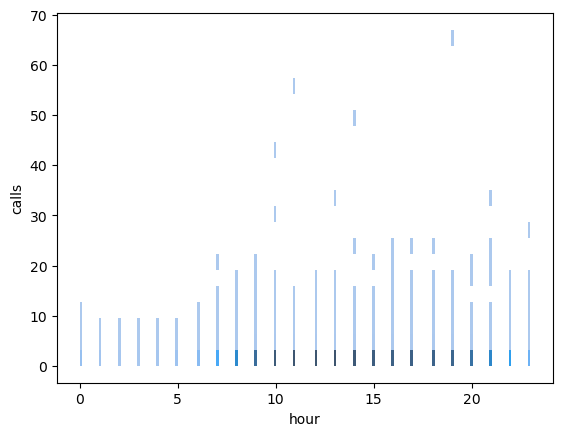

In [28]:
sns.histplot(plot_df,x="hour", y="calls")
plt.show()

In [33]:
plt.savefig("work/hours-calls-histogram.png")

<Figure size 640x480 with 0 Axes>

In [32]:
spark.stop()